
# HDAB ➜ StarDist ➜ Dataset-wide Binning ➜ H-score 


## 1) Configure paths and parameters

In [ ]:

from pathlib import Path
DATA_DIR = Path("/Users/jamieannemortel/Documents/IHC_dataset")  
OUT_DIR  = Path("results_notebook")
RECURSIVE = False  # set True to search subfolders

# StarDist settings
PROBABILITY_THRESHOLD = 0.25
NMS_THRESHOLD = 0.6

# Quality filters
MINIMUM_AREA_PIXELS = 20
MINIMUM_MEAN_OD = 0.02

# Dataset-wide binning
BIN_METRIC = "p99"            # choose: "p99", "mean", "median"
BIN_STRATEGY = "multiotsu"    # choose: "multiotsu" or "quantile"
QUANTILE_1 = 0.33             # used if BIN_STRATEGY == "quantile"
QUANTILE_2 = 0.66

"""
PROBABILITY_THRESHOLD

Meaning: The minimum predicted probability for a region to be considered a valid object (cell).

Effect: Lowering this value allows StarDist to accept lower-confidence detections — i.e., more cells, but also more false positives.

Change to detect more cells:

PROBABILITY_THRESHOLD = 0.3  # or even 0.25


NMS_THRESHOLD (Non-Maximum Suppression)

Meaning: Controls how much overlap between predicted cells is allowed before one is suppressed.

Effect: Increasing this value allows more overlapping detections to remain, which can help detect touching or clumped cells.

Change to detect more cells:

NMS_THRESHOLD = 0.5  # or up to 0.6
"""


'\nPROBABILITY_THRESHOLD\n\nMeaning: The minimum predicted probability for a region to be considered a valid object (cell).\n\nEffect: Lowering this value allows StarDist to accept lower-confidence detections — i.e., more cells, but also more false positives.\n\nChange to detect more cells:\n\nPROBABILITY_THRESHOLD = 0.3  # or even 0.25\n\n\nNMS_THRESHOLD (Non-Maximum Suppression)\n\nMeaning: Controls how much overlap between predicted cells is allowed before one is suppressed.\n\nEffect: Increasing this value allows more overlapping detections to remain, which can help detect touching or clumped cells.\n\nChange to detect more cells:\n\nNMS_THRESHOLD = 0.5  # or up to 0.6\n'

## 2) Imports

In [2]:

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from skimage import io as skio, exposure, util, measure
from skimage.color import rgb2hed
from skimage.filters import threshold_multiotsu
from tifffile import imread, imsave
from csbdeep.utils import normalize
from stardist.models import StarDist2D

plt.rcParams['figure.dpi'] = 140
OUT_DIR.mkdir(parents=True, exist_ok=True)


bioimageio_utils.py (2): pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
2025-10-27 15:11:20.098398: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 3) Utility functions

In [3]:
from pathlib import Path

IMAGE_EXTENSIONS = {".tif", ".tiff", ".png", ".jpg", ".jpeg", ".bmp"}
COLOR_LOW, COLOR_MEDIUM, COLOR_HIGH = (90, 160, 255), (240, 200, 120), (255, 100, 70)


def is_image_file(path: Path): 
    return path.is_file() and path.suffix.lower() in IMAGE_EXTENSIONS

def list_images(data_dir: Path, recursive: bool):
    if recursive:
        return sorted([p for p in data_dir.rglob("*") if is_image_file(p)])
    else:
        return sorted([p for p in data_dir.iterdir() if is_image_file(p)])

def read_image_rgb(path: Path):
    img = imread(str(path)) if path.suffix.lower() in (".tif",".tiff") else skio.imread(str(path))
    if img.ndim == 2:
        img = np.stack([img, img, img], axis=-1)
    return img

#  OD-based DAB  

def _rgb_to_brightness01(rgb_float):
    """Return brightness in [0,1] from float RGB [0,1]."""
    r, g, b = rgb_float[...,0], rgb_float[...,1], rgb_float[...,2]
    gray = 0.299*r + 0.587*g + 0.114*b
    gray = np.clip(gray, 0.0, 1.0)
    return gray

def _choose_dab_sign(dab_od, rgb_float):
    """
    Decide whether to use DAB or -DAB by asking:
    does it correlate positively with 'darkness' (1 - brightness)?
    We pick the sign that yields the higher positive correlation to darkness.
    """
    darkness = 1.0 - _rgb_to_brightness01(rgb_float)
    a = dab_od.ravel()
    b = (-dab_od).ravel()
    d = darkness.ravel()
    # Pearson correlations (fast, good enough)
    # (add tiny eps to avoid NaNs if constant)
    eps = 1e-12
    def corr(x, y):
        x = x - x.mean(); y = y - y.mean()
        return float((x*y).mean() / (x.std()+eps) / (y.std()+eps))
    corr_a = corr(a, d)
    corr_b = corr(b, d)
    return dab_od if corr_a >= corr_b else -dab_od

def compute_dab_od(rgb_uint8, baseline_percentile=1.0, auto_sign=True):
    """
    Return a DAB optical density map (OD units, not 0–1 scaled).
    Steps:
      1) rgb2hed → take D channel (DAB)
      2) optional sign fix so brown → higher OD
      3) optional baseline shift by a low percentile (e.g., 1%) so background ≈ 0
    """
    # to float [0,1]
    rgb_float = util.img_as_float(np.clip(rgb_uint8, 0, 255))
    hed = rgb2hed(rgb_float)
    dab_od = hed[..., 2]                    # OD-like DAB channel

    if auto_sign:
        dab_od = _choose_dab_sign(dab_od, rgb_float)

    # baseline shift only (no scaling):
    if baseline_percentile is not None:
        base = np.percentile(dab_od, baseline_percentile)
        dab_od = dab_od - base

    return dab_od  # OD units (can be negative if baseline > background)

#  plotting 

def save_histogram_and_cdf(values, out_png, title):
    values = np.asarray(values)
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))
    axes[0].hist(values, bins=60)
    axes[0].set_title(f"Histogram: {title}")
    axes[0].set_xlabel("DAB optical density (OD units)")
    axes[0].set_ylabel("Count")
    xs = np.sort(values)
    ys = np.arange(1, len(xs) + 1) / len(xs)
    axes[1].plot(xs, ys)
    axes[1].set_title(f"CDF: {title}")
    axes[1].set_xlabel("DAB optical density (OD units)")
    axes[1].set_ylabel("Cumulative fraction")
    fig.tight_layout()
    fig.savefig(out_png, dpi=200, bbox_inches="tight")
    plt.show()

def make_overlay(display_rgb, labels, nuclei_with_classes, title, out_png):
    overlay = np.zeros((*labels.shape, 3), np.uint8)
    if nuclei_with_classes is not None and len(nuclei_with_classes) > 0:
        cmap = {1: COLOR_LOW, 2: COLOR_MEDIUM, 3: COLOR_HIGH}
        for _, row in nuclei_with_classes.iterrows():
            overlay[labels == int(row["label"])] = cmap[int(row["class_lmh"])]
    else:
        overlay[labels > 0] = COLOR_MEDIUM

    plt.figure(figsize=(6,6))
    plt.imshow(display_rgb)
    plt.imshow(overlay, alpha=0.45)
    plt.axis("off")
    plt.title(title)
    plt.show()
    imsave(str(out_png), overlay)
    return overlay


## 4) Load StarDist model

In [4]:

print("Loading StarDist model '2D_versatile_he'…")
stardist_model = StarDist2D.from_pretrained("2D_versatile_he")
print("Model ready.")


Loading StarDist model '2D_versatile_he'…
Found model '2D_versatile_he' for 'StarDist2D'.


2025-10-27 15:11:23.772980: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-10-27 15:11:23.773503: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-10-27 15:11:23.773531: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-10-27 15:11:23.775829: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-10-27 15:11:23.776228: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.
Model ready.


## 5) Pass 1 — Segment and collect per-nucleus metrics across the dataset

In [5]:
def segment_cells_enhanced(
    image,
    stardist_model,
    prob_thresh=0.5,
    nms_thresh=0.3,
    min_area=80,
    fill_holes=True,
    hole_area=64,
    watershed_split=True,
):
    import numpy as np
    from skimage.morphology import remove_small_objects, remove_small_holes, local_maxima
    from skimage.segmentation import watershed
    from skimage.measure import label
    from scipy import ndimage as ndi

    # predict
    labels, _ = stardist_model.predict_instances(
        image, prob_thresh=prob_thresh, nms_thresh=nms_thresh, axes="YXC"
    )

    if min_area > 0:
        labels = remove_small_objects(labels, min_size=min_area)

    if fill_holes:
        mask = labels > 0
        mask = remove_small_holes(mask, area_threshold=hole_area)
        labels = mask.astype(np.uint16) * labels

    if watershed_split:
        mask = labels > 0
        dist = ndi.distance_transform_edt(mask)
        # <-- changed line
        maxima = local_maxima(dist)
        markers = label(maxima)
        labels = watershed(-dist, markers, mask=mask)

    return labels, None


In [6]:

# ================================
# 5) Pass 1 (FIXED)
# - Run StarDist segmentation first to produce `labels`
# - Then compute per-cell DAB OD statistics
# - Avoids using undefined variables and duplicate segmentation
# ================================

# Expect the following to be defined earlier in the notebook:
#   DATA_DIR, RECURSIVE, BIN_METRIC, PROBABILITY_THRESHOLD, NMS_THRESHOLD,
#   MINIMUM_AREA_PIXELS, list_images, read_image_rgb, compute_dab_od,
#   normalize, rgb2hed, util, exposure, np, pd, measure, stardist_model

image_paths = list_images(DATA_DIR, RECURSIVE)
assert len(image_paths) > 0, f"No images found in {DATA_DIR}"

metric_map = {"p99":"p99_dab_od", "mean":"mean_dab_od", "median":"median_dab_od"}
metric_col = metric_map[BIN_METRIC]

all_tables = []
for path in image_paths:
    # ----------------
    # Load & prep RGB
    # ----------------
    rgb = read_image_rgb(path)
    if rgb.shape[-1] == 4:           # drop alpha if present
        rgb = rgb[..., :3]
    display_rgb = exposure.rescale_intensity(rgb, out_range=np.uint8).astype(np.uint8)

    # ------------------------------
    # Deconvolution + DAB OD signal
    # ------------------------------
    hed = rgb2hed(util.img_as_float(np.clip(rgb, 0, 1)))
    H = hed[..., 0]  # may be useful later

    # Use OD units (no 0–1 scaling); auto sign + baseline shift by 1st percentile
    D_od = compute_dab_od(display_rgb, baseline_percentile=1.0, auto_sign=True)

    # ----------------------------------------------------
    # StarDist expects normalized RGB (YXC) for this model
    # ----------------------------------------------------
    rgb_norm = np.stack([normalize(rgb[..., c], 1, 99.8) for c in range(3)], axis=-1)

    # ---------------------------
    # Segment FIRST -> get labels
    # ---------------------------
    labels, _ = segment_cells_enhanced(
        image=rgb_norm,
        stardist_model=stardist_model,
        prob_thresh=PROBABILITY_THRESHOLD,
        nms_thresh=NMS_THRESHOLD,
        min_area=0,                # keep small objects for now; we'll filter with MINIMUM_AREA_PIXELS below
        fill_holes=True,
        hole_area=64,
        watershed_split=True
    )

    # ---------------------------------------------
    # Now measure per-cell properties using DAB OD
    # ---------------------------------------------
    props = measure.regionprops(labels, intensity_image=D_od)
    rows = []
    for prop in props:
        if prop.area < MINIMUM_AREA_PIXELS:
            continue

        vals = D_od[labels == prop.label]
        mean_v   = float(vals.mean())
        median_v = float(np.median(vals))
        p99_v    = float(np.percentile(vals, 99))

        # Optionally drop very faint cells
        if (mean_v < MINIMUM_MEAN_OD) and (p99_v < MINIMUM_MEAN_OD):
            continue

        cy, cx = prop.centroid
        rows.append(dict(
            image_name=path.name if hasattr(path, 'name') else str(path),
            label=int(prop.label),
            center_x=float(cx),
            center_y=float(cy),
            area_pixels=int(prop.area),
            mean_dab_od=mean_v,
            median_dab_od=median_v,
            p99_dab_od=p99_v
        ))

    df = pd.DataFrame(rows)
    detected = int(labels.max()) if labels.size else 0
    print(f"[Pass1] {path.name if hasattr(path, 'name') else str(path)}: detected={detected} kept={len(df)}")
    all_tables.append(df)

nuclei_all = pd.concat(all_tables, ignore_index=True) if all_tables else pd.DataFrame()
nuclei_all.head()



2025-10-27 15:11:25.789091: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[Pass1] 02576bc0-375f-4773-bdb1-1a4480eaa2ee.png: detected=1036 kept=347


2025-10-27 15:11:28.518877: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[Pass1] Screenshot 2025-10-27 at 3.04.54 PM.png: detected=227 kept=227


,image_name,label,center_x,center_y,area_pixels,mean_dab_od,median_dab_od,p99_dab_od
0,02576bc0-375f-4773-bdb1-1a4480eaa2ee.png,1,134.294118,3.294118,136,0.102131,0.101881,0.143261
1,02576bc0-375f-4773-bdb1-1a4480eaa2ee.png,2,633.916399,6.144695,311,0.129905,0.125728,0.217519
2,02576bc0-375f-4773-bdb1-1a4480eaa2ee.png,4,539.738806,9.264925,268,0.142406,0.145141,0.225244
3,02576bc0-375f-4773-bdb1-1a4480eaa2ee.png,7,685.160305,14.488550,131,0.006891,0.005069,0.026934
4,02576bc0-375f-4773-bdb1-1a4480eaa2ee.png,9,225.283688,11.907801,141,0.106338,0.109692,0.159508


## 8) Learn dataset-wide thresholds (Multi-Otsu or Quantiles)

In [7]:
from skimage.filters import threshold_multiotsu

# pick which intensity metric to threshold on
metric_map = {"p99": "p99_dab_od", "mean": "mean_dab_od", "median": "median_dab_od"}
metric_col = metric_map[BIN_METRIC]

# extract valid positive values only (e.g. remove NaNs and negatives)
values_after = nuclei_all[metric_col].dropna().values
values_after = values_after[values_after > 0]


# Decide which strategy: "multiotsu" or "quantile"
if BIN_STRATEGY == "multiotsu":
    thresholds = threshold_multiotsu(values_after, classes=3)
    threshold_low, threshold_high = float(thresholds[0]), float(thresholds[1])
else:
    threshold_low  = float(np.quantile(values_after, QUANTILE_1))
    threshold_high = float(np.quantile(values_after, QUANTILE_2))

print(
    f"Thresholds on '{BIN_METRIC}': "
    f"low<{threshold_low:.4f}, medium<{threshold_high:.4f}, high≥{threshold_high:.4f}"
)



Thresholds on 'p99': low<0.2910, medium<0.7758, high≥0.7758


## 9) Pass 2 — Classify nuclei, compute H-scores, and save per-image outputs

In [8]:
# Controls whether to remove intensity values outside the clipping range
DROP_OUT_OF_CLIP = False     # or False, depending on what you want


1595921092.py (53): <tifffile.imsave> is deprecated. Use tifffile.imwrite


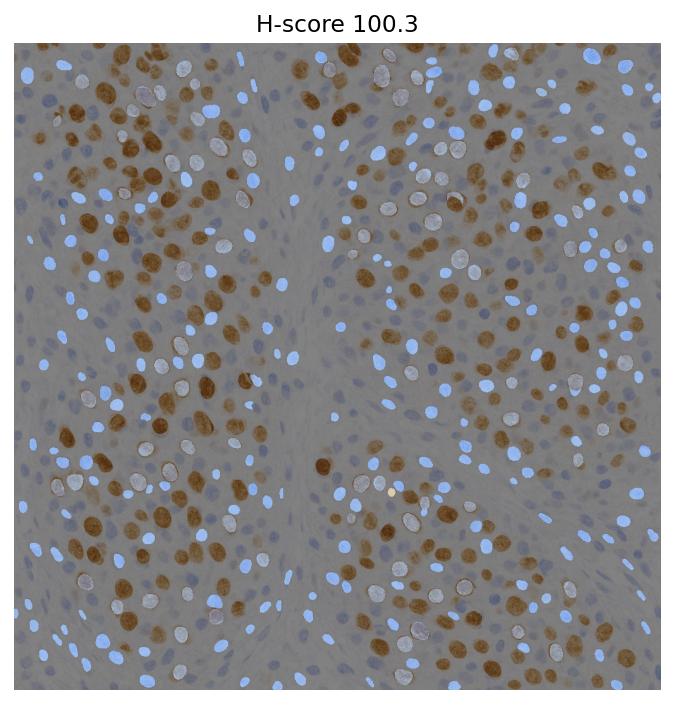

1410761772.py (108): <tifffile.imsave> is deprecated. Use tifffile.imwrite


ValueError: the input array must have size 3 along `channel_axis`, got (1232, 1228, 4)

In [9]:

summary_rows = []
for image_name, group in nuclei_all.groupby("image_name"):
    image_stem = Path(image_name).stem
    out_img_dir = OUT_DIR / image_stem
    out_img_dir.mkdir(parents=True, exist_ok=True)

    # Rebuild labels for overlay
    path = next(p for p in list_images(DATA_DIR, RECURSIVE) if p.name == image_name)
    rgb = read_image_rgb(path)
    display_rgb = exposure.rescale_intensity(rgb, out_range=np.uint8).astype(np.uint8)
    hed = rgb2hed(util.img_as_float(np.clip(rgb, 0, 1)))
    H = hed[..., 0]
    D = hed[..., 2]
    # D_norm = normalize_0_1(D)
    # H_in = normalize(H, 1, 99.8)
    # labels, _ = stardist_model.predict_instances(H_in, prob_thresh=PROBABILITY_THRESHOLD, nms_thresh=NMS_THRESHOLD)
    # number_detected = int(labels.max())
    # Use OD-based DAB for quantification (no 0–1 scaling, if you added compute_dab_od):
    # D_od = compute_dab_od(display_rgb, baseline_percentile=1.0, auto_sign=True)

    # For StarDist, feed RGB (model '2D_versatile_he' expects YXC)
    if rgb.shape[-1] == 4:  # drop alpha if present
        rgb = rgb[..., :3]
    rgb_norm = np.stack([normalize(rgb[..., c], 1, 99.8) for c in range(3)], axis=-1)

    labels, _ = stardist_model.predict_instances(
        rgb_norm, axes="YXC",
        prob_thresh=PROBABILITY_THRESHOLD, nms_thresh=NMS_THRESHOLD
    )
    number_detected = int(labels.max())


    if DROP_OUT_OF_CLIP:
        inside = (group[metric_col] >= lower_clip) & (group[metric_col] <= upper_clip)
        group = group[inside].reset_index(drop=True)

    number_kept = len(group)
    if number_kept > 0:
        vals = group[metric_col].values
        classes = np.zeros(number_kept, np.int32)
        classes[vals < threshold_low] = 1
        classes[(vals >= threshold_low) & (vals < threshold_high)] = 2
        classes[vals >= threshold_high] = 3
        group = group.copy()
        group["class_lmh"] = classes

        percent_low    = 100.0 * np.mean(classes == 1)
        percent_medium = 100.0 * np.mean(classes == 2)
        percent_high   = 100.0 * np.mean(classes == 3)
        h_score = 1*percent_low + 2*percent_medium + 3*percent_high

        group.to_csv(out_img_dir / f"{image_stem}_per_nucleus_metrics.csv", index=False)
        imsave(str(out_img_dir / f"{image_stem}_labels.tif"), labels.astype(np.uint16))
        _ = make_overlay(display_rgb, labels, group, f"H-score {h_score:.1f}", out_img_dir / f"{image_stem}_overlay.png")
    else:
        percent_low = percent_medium = percent_high = 0.0
        h_score = 0.0
        imsave(str(out_img_dir / f"{image_stem}_labels.tif"), labels.astype(np.uint16))
        _ = make_overlay(display_rgb, labels, None, "No kept nuclei", out_img_dir / f"{image_stem}_overlay.png")

    summary_rows.append(dict(
        image_name=image_name,
        number_detected=number_detected,
        number_kept=number_kept,
        threshold_low=threshold_low,
        threshold_high=threshold_high,
        percent_low=percent_low,
        percent_medium=percent_medium,
        percent_high=percent_high,
        h_score=h_score
    ))

dataset_summary = pd.DataFrame(summary_rows)
dataset_summary.to_csv(OUT_DIR / "dataset_summary.csv", index=False)
dataset_summary.head()


## 10) Save `nuclei_all.csv` and preview outputs

In [ ]:

nuclei_all.to_csv(OUT_DIR / "nuclei_all.csv", index=False)
print("Saved:", OUT_DIR / "dataset_summary.csv")
print("Saved:", OUT_DIR / "nuclei_all.csv")


Saved: results_notebook/dataset_summary.csv
Saved: results_notebook/nuclei_all.csv
